<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250127%5D%20Hybrid%20LR-Bi-LSTM%20for%2010%20class%20on%20UNSW-NB15%20dataset%20with%20CW%20and%20PGD%20attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Hybrid LR-Bi-LSTM for 10 class based on UNSW-NB15 dataset with CW and PGD attacks**

In [1]:
!pip install foolbox # Install the foolbox library

In [2]:
# Revised Code
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import foolbox as fb  # For CW and PGD attacks

In [3]:
# Load dataset
dataset = pd.read_csv("Dataset_10Classes.csv")

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [4]:
dataset

,ID_Cb,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,Class
0,1,1,0.121478,tcp,-,FIN,6,4,258,172,...,1,0,0,0,1,1,0,Normal,0,0
1,2,2,0.649902,tcp,-,FIN,14,38,734,42014,...,2,0,0,0,1,6,0,Normal,0,0
2,3,3,1.623129,tcp,-,FIN,8,16,364,13186,...,3,0,0,0,2,6,0,Normal,0,0
3,4,4,1.681642,tcp,ftp,FIN,12,12,628,770,...,3,1,1,0,2,1,0,Normal,0,0
4,5,5,0.449454,tcp,-,FIN,10,6,534,268,...,40,0,0,0,2,39,0,Normal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,257669,82328,0.000005,udp,-,INT,2,0,104,0,...,2,0,0,0,2,1,0,Normal,0,0
257669,257670,82329,1.106101,tcp,-,FIN,20,8,18062,354,...,1,0,0,0,3,2,0,Normal,0,0
257670,257671,82330,0.000000,arp,-,INT,1,0,46,0,...,1,0,0,0,1,1,1,Normal,0,0
257671,257672,82331,0.000000,arp,-,INT,1,0,46,0,...,1,0,0,0,1,1,1,Normal,0,0


**Data Preprocessing**

In [5]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [93000  2677  2329 16353 44525 24246 58871 13987  1511   174]


In [6]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
from imblearn.over_sampling import SMOTE

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [93000 93000 93000 93000 93000 93000 93000 93000 93000 93000]


In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Hybrid combination of LR-Bi-LSTM for 10 class classifications on UNSW-NB15 with CW and PGD attacks**

**# --- Logistic Regression Model ---**

In [9]:
# --- Logistic Regression Model ---
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

# Extract LR probabilities
train_lr_features = lr_model.predict_proba(X_train)
test_lr_features = lr_model.predict_proba(X_test)
train_lr_features = np.expand_dims(train_lr_features, axis=1)
test_lr_features = np.expand_dims(test_lr_features, axis=1)

# One-hot encoding for labels
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


**# --- Define Bi-LSTM Model ---**

In [10]:
# --- Define Bi-LSTM Model ---
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001)), input_shape=(1, train_lr_features.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.0001))),
    Dropout(0.2),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.0001))
])
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- Train the Model ---
start_time = time.time()
history = bilstm_model.fit(train_lr_features, y_train, validation_split=0.2, epochs=50, batch_size=64, verbose=1)
end_time = time.time()

# Evaluate on test set
test_predictions = bilstm_model.predict(test_lr_features)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Performance Metrics
accuracy = accuracy_score(true_labels, test_predictions_labels)
precision = precision_score(true_labels, test_predictions_labels, average='macro')
recall = recall_score(true_labels, test_predictions_labels, average='macro')
f1 = f1_score(true_labels, test_predictions_labels, average='macro')
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 69s 7ms/step - accuracy: 0.9950 - loss: 0.1835 - val_accuracy: 0.9999 - val_loss: 0.0172
Epoch 2/50
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 63s 7ms/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 1.0000 - val_loss: 0.0152
Epoch 3/50
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 64s 7ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.9999 - val_loss: 0.0149
Epoch 4/50
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 64s 7ms/step - accuracy: 0.9999 - loss: 0.0156 - val_accuracy: 1.0000 - val_loss: 0.0149
Epoch 5/50
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 66s 7ms/step - accuracy: 1.0000 - loss: 0.0155 - val_accuracy: 0.9999 - val_loss: 0.0148
Epoch 6/50
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 65s 7ms/step - accuracy: 0.9999 - loss: 0.0155 - val_accuracy: 0.9999 - val_loss: 0.0148
Epoch 7/50
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 65s 7ms/step - accuracy: 1.0000 - loss: 0.0154 - val_accuracy: 0.9999 - val_loss: 0.0148
Epoch 8/50
9300/9300 ━━━━━━━━━━━━━━━━━━━━ 64s 7ms/step - accuracy: 1.0000 - loss: 0

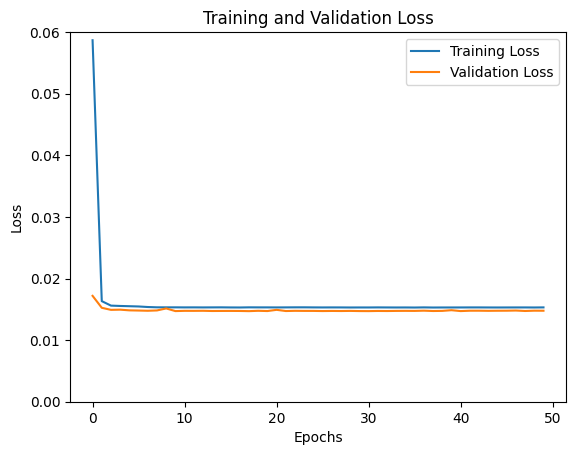

In [11]:
# prompt: please illustrate training loss and validation loss graph through all epochs with Loss axis scale 0 -1

import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by bilstm_model.fit
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.06)  # Set the y-axis limit to 0-1
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

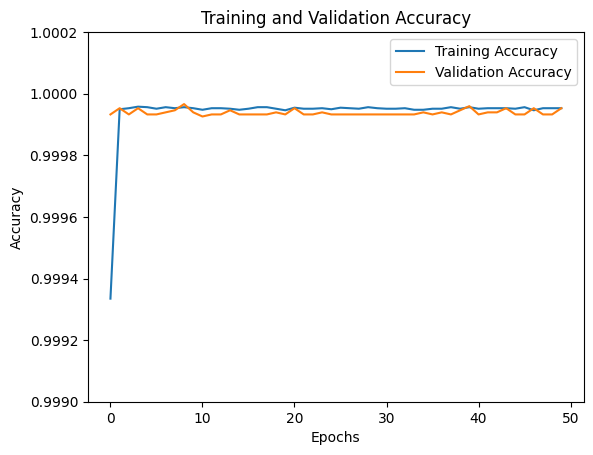

In [12]:
# prompt: Please plot the graph of training accuracy and validation accuracy through the epochs

import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by bilstm_model.fit
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.9990, 1.0002)  # Set the y-axis limit to 0-1
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

**# --- Adversarial Robustness Testing ---**

In [22]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
import numpy as np
import foolbox as fb

def evaluate_adversarial_robustness_optimized(
    model, test_features, test_labels, epsilon=0.1, batch_size=128, max_samples=1000
):
    """
    Optimized function to evaluate adversarial robustness using PGD and CW attacks.

    Parameters:
        model: Trained TensorFlow/Keras model.
        test_features: Test features (input data).
        test_labels: True labels of the test data.
        epsilon: Perturbation magnitude for PGD and CW attacks.
        batch_size: Batch size for robustness evaluation.
        max_samples: Maximum number of samples to evaluate adversarial robustness.

    Returns:
        pgd_accuracy: Accuracy under PGD attack.
        cw_accuracy: Accuracy under CW attack.
    """
    # Reduce dataset size for evaluation
    sampled_indices = np.random.choice(len(test_features), size=min(max_samples, len(test_features)), replace=False)
    sampled_features = tf.convert_to_tensor(test_features[sampled_indices], dtype=tf.float32)
    sampled_labels = tf.convert_to_tensor(test_labels[sampled_indices], dtype=tf.int32)

    # Initialize Foolbox model wrapper
    fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

    # --- PGD Attack ---
    pgd_attack = fb.attacks.LinfPGD(steps=50)  # Reduced number of steps for faster computation
    adversarial_examples_pgd = []
    for i in range(0, len(sampled_features), batch_size):
        batch_features = sampled_features[i : i + batch_size]
        batch_labels = sampled_labels[i : i + batch_size]

        # Get adversarial examples directly, instead of success flags
        adversarial_batch, _, _ = pgd_attack(fmodel, batch_features, criterion=fb.criteria.Misclassification(batch_labels), epsilons=epsilon)

        # Ensure adversarial_batch is a float tensor
        adversarial_batch = tf.cast(adversarial_batch, dtype=tf.float32)
        adversarial_examples_pgd.append(adversarial_batch)
    adversarial_examples_pgd = tf.concat(adversarial_examples_pgd, axis=0)

    # Evaluate PGD attack
    pgd_predictions = np.argmax(model.predict(adversarial_examples_pgd), axis=1)
    pgd_accuracy = accuracy_score(sampled_labels.numpy(), pgd_predictions)


     # --- CW Attack ---
    cw_attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=3, steps=100)  # Reduced steps
    adversarial_examples_cw = []
    for i in range(0, len(sampled_features), batch_size):
        batch_features = sampled_features[i : i + batch_size]
        batch_labels = sampled_labels[i : i + batch_size]

        # Get adversarial examples directly for CW attack
        adversarial_batch, _, _ = cw_attack(fmodel, batch_features, criterion=fb.criteria.Misclassification(batch_labels), epsilons=epsilon)

        # Ensure adversarial_batch is a float tensor
        adversarial_batch = tf.cast(adversarial_batch, dtype=tf.float32)
        adversarial_examples_cw.append(adversarial_batch)
    adversarial_examples_cw = tf.concat(adversarial_examples_cw, axis=0)

    # Evaluate CW attack
    cw_predictions = np.argmax(model.predict(adversarial_examples_cw), axis=1)
    cw_accuracy = accuracy_score(sampled_labels.numpy(), cw_predictions)

    return pgd_accuracy, cw_accuracy


# Call the optimized function
pgd_accuracy, cw_accuracy = evaluate_adversarial_robustness_optimized(
    bilstm_model, test_lr_features, true_labels, epsilon=0.1, batch_size=64, max_samples=500
)

print(f"Optimized PGD Attack Accuracy: {pgd_accuracy:.10f}")
print(f"Optimized CW Attack Accuracy: {cw_accuracy:.10f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Optimized PGD Attack Accuracy: 1.0000000000
Optimized CW Attack Accuracy: 0.0880000000


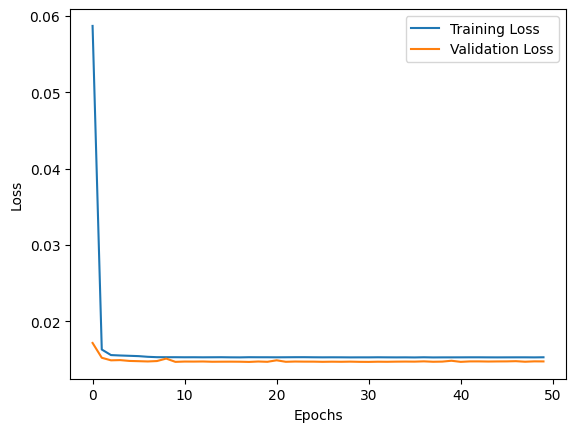

In [23]:
# --- Plot Training and Validation Loss ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()